#### 필요한 라이브러리 설치

In [ ]:
! pip install torch torchvision transformers faiss-cpu scikit-learn pillow numpy matplotlib opencv-python


In [3]:
import numpy as np
from PIL import Image
from torchvision import transforms

"""
이미지 전처리 파이프라인 정의

transforms.Resize-> 224*224 픽셀로 크기 고정(∵ 모델이 고정된 입력 크기를 필요로함)
transforms.ToTensor-> 이미지를 PyTorch 텐서로 변환
transforms.Normalize-> 이미지를 정규화: 이미지의 각 채널-> R,G,B를 정규화
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]: R,G,B 채널 평균 및 표준편차

"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 이미지 전처리 함수
def preprocess_image(img_path):
    # 이미지를 여고 RGB로 변환->근데 다른 기준으로 삼아서 다시 해봐야할듯
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0)  # 모델이 배치 단위로 입력받기 위해 배치 차원 추가(1, 3, 224, 224)


In [6]:
! pip install torch

#### 이미지 특징 추출 및 유사도 측정(1): 코사인 유사도 사용

Image 1 Feature Vector: [ 5.58396637e-01  2.02381715e-01  4.10164818e-02 -2.55144298e-01
 -3.96573767e-02  6.02371544e-02 -1.42428800e-01  4.46140736e-01
  4.92826670e-01 -6.57623112e-02 -1.06824718e-01  2.32090905e-01
  2.17073083e-01  5.22503197e-01 -4.54323031e-02  3.09287012e-01
 -1.00189120e-01 -2.77340263e-01 -8.12491775e-02 -5.47977746e-01
  4.35649186e-01  2.05225796e-01  2.17333570e-01 -1.01531819e-01
 -3.84788573e-01 -1.65455699e-01  7.23414570e-02 -4.64167982e-01
  8.04105997e-02 -2.87905246e-01 -2.64337689e-01  7.70783201e-02
 -1.48635224e-01 -1.40147701e-01  7.13775381e-02 -1.43251002e-01
 -2.33292788e-01  1.55005455e-01 -4.82280374e-01  1.19521952e+00
  1.83438972e-01 -5.64377904e-01  1.23750970e-01  1.29314288e-01
 -8.11573386e-01  6.30462728e-03  1.83433592e-01  2.15559483e-01
 -1.29594281e-01 -3.11284602e-01  6.89872384e-01 -6.23493940e-02
  3.92416194e-02 -2.06349716e-01 -2.54233748e-01  1.38941780e-02
  2.71993279e-01  2.36418098e-01  1.41686201e-02 -2.31738731e-01
 

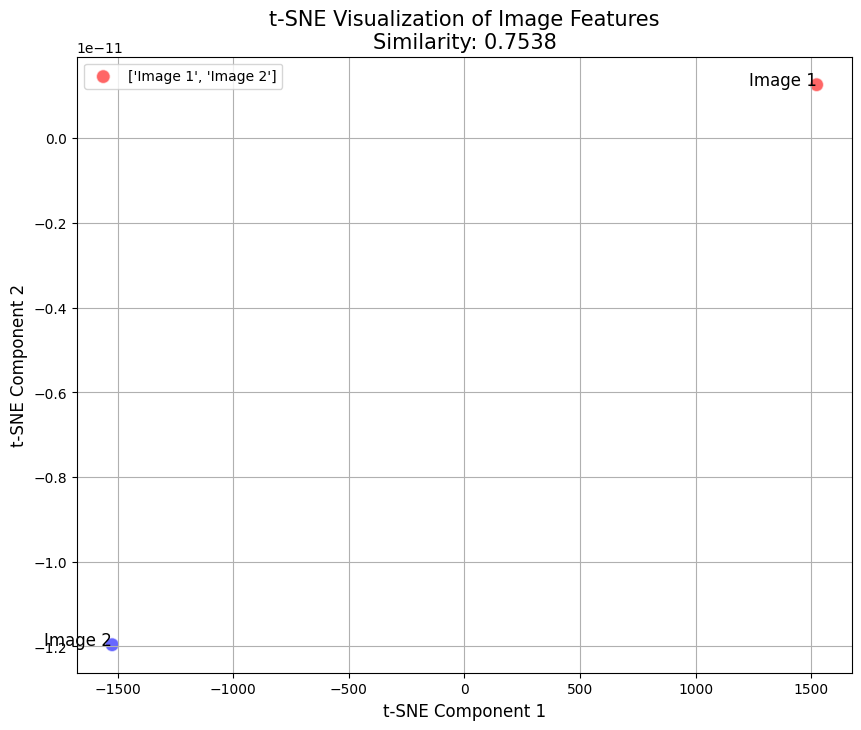

In [5]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# CLIP 모델 및 프로세서 로드
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

#모델 평가 모드로 설정(∵ 모델 추론시 필요)
clip_model.eval()

# CLIP 특징 추출 함수
def extract_clip_features(img_path):
    image = Image.open(img_path).convert("RGB")

    #이미지 CLIP 프로세서 사용해서 전처리, 파이토치 텐서 형식으로 변환
    inputs = clip_processor(images=image, return_tensors="pt")

    # 추론시에는 그라디언트 계산 불필요(메모리 절약)
    with torch.no_grad():
        # CLIP 모델로 이미지 특징 추출
        outputs = clip_model.get_image_features(**inputs)
    return outputs.squeeze().numpy()  # 추출된 특징 벡터 numpy 배열로 변환

# 이미지에서 특징 벡터 추출
clip_feat1 = extract_clip_features("./ex_data/image_1.jpeg")
clip_feat2 = extract_clip_features("./ex_data/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg")


# 특징 벡터 출력->각 이미지에 해당되는 특징 벡터 확인
print("Image 1 Feature Vector:", clip_feat1)
print("Image 2 Feature Vector:", clip_feat2)

# 유사도 측정 (코사인 유사도)
similarity = cosine_similarity([clip_feat1], [clip_feat2])[0][0]
print(f"CLIP 기반 유사도: {similarity:.4f}")

# 리스트를 numpy 배열로 변환
features = np.array([clip_feat1, clip_feat2])

# t-SNE를 사용하여 2차원으로 축소 (perplexity 값을 1로 설정)
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
features_2d = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=['red', 'blue'], s=100, alpha=0.6, edgecolors='w', label=['Image 1', 'Image 2'])
for i, txt in enumerate(['Image 1', 'Image 2']):
    plt.annotate(txt, (features_2d[i, 0], features_2d[i, 1]), fontsize=12, ha='right')

plt.legend(loc='best')
plt.title(f"t-SNE Visualization of Image Features\nSimilarity: {similarity:.4f}", fontsize=15)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True)
plt.show()

In [4]:
import os
print("현재 실행 디렉토리:", os.getcwd())


현재 실행 디렉토리: c:\Users\LG\elice\sketch2furnish\similarity


#### 이미지 특징 추출 및 유사도 측정(2): 유클리드 거리 유사도 사용

유클리드 거리: 7.5197


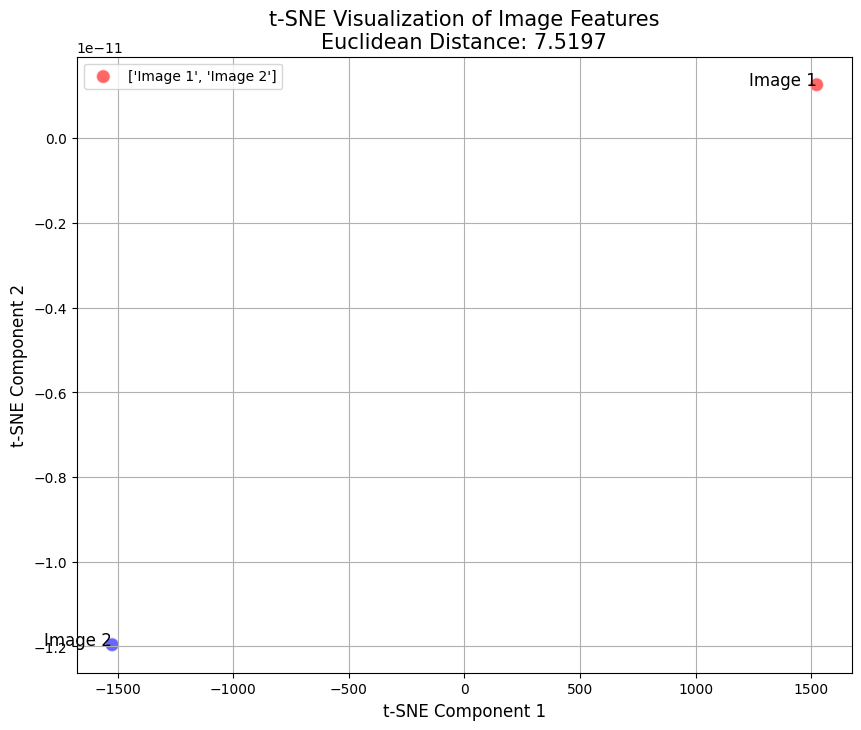

In [13]:
#유클리드 거리 유사도
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
import numpy as np

# CLIP 모델 및 프로세서 로드
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
clip_model.eval()

# CLIP 특징 추출 함수
def extract_clip_features(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs.squeeze().numpy()  # (768차원)

# 이미지에서 특징 벡터 추출
clip_feat1 = extract_clip_features("archive/chair_dataset/image_1.jpeg")
clip_feat2 = extract_clip_features("Furniture Detection.v3i.coco/train/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg")

# 유클리드 거리 측정
euclidean_distance = euclidean(clip_feat1, clip_feat2)
print(f"유클리드 거리: {euclidean_distance:.4f}")

# 리스트를 numpy 배열로 변환
features = np.array([clip_feat1, clip_feat2])

# t-SNE를 사용하여 2차원으로 축소 (perplexity 값을 1로 설정)
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
features_2d = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=['red', 'blue'], s=100, alpha=0.6, edgecolors='w', label=['Image 1', 'Image 2'])
for i, txt in enumerate(['Image 1', 'Image 2']):
    plt.annotate(txt, (features_2d[i, 0], features_2d[i, 1]), fontsize=12, ha='right')

plt.legend(loc='best')
plt.title(f"t-SNE Visualization of Image Features\nEuclidean Distance: {euclidean_distance:.4f}", fontsize=15)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True)
plt.show()


#### 이미지 특징 추출 및 유사도 측정(3): 맨해튼 유사도 사용

맨해튼 거리: 131.5491


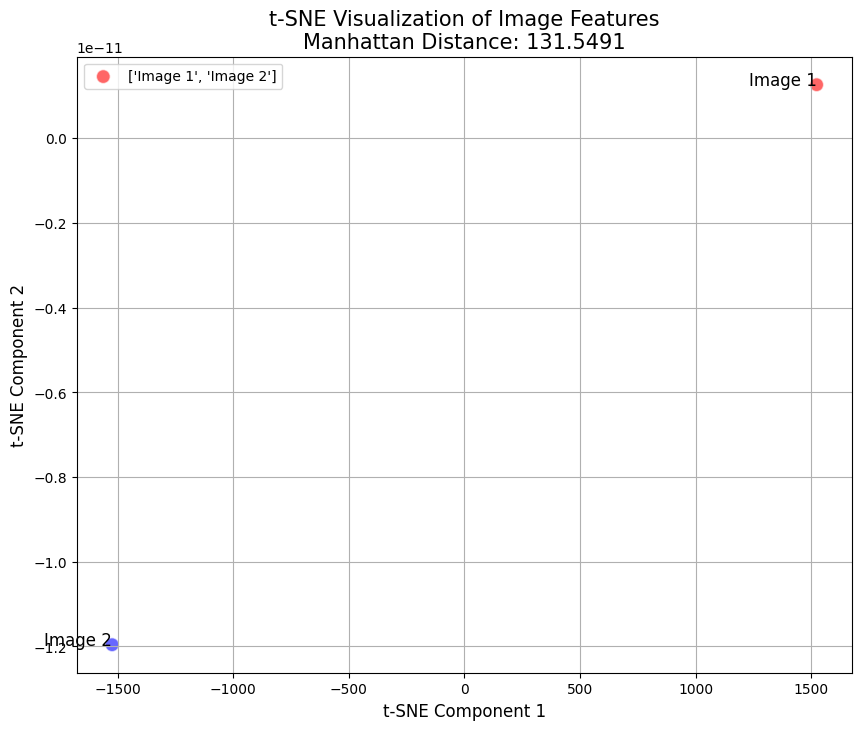

In [14]:
#맨해튼 거리 유사도
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
import numpy as np

# CLIP 모델 및 프로세서 로드
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
clip_model.eval()

# CLIP 특징 추출 함수
def extract_clip_features(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs.squeeze().numpy()  # (768차원)

# 이미지에서 특징 벡터 추출
clip_feat1 = extract_clip_features("archive/chair_dataset/image_1.jpeg")
clip_feat2 = extract_clip_features("Furniture Detection.v3i.coco/train/c--88-_jpeg_jpg.rf.e1904e5f6ec8799cbb585551aafbaab1.jpg")

# 맨해튼 거리 측정
manhattan_distance = cityblock(clip_feat1, clip_feat2)
print(f"맨해튼 거리: {manhattan_distance:.4f}")

# 리스트를 numpy 배열로 변환
features = np.array([clip_feat1, clip_feat2])

# t-SNE를 사용하여 2차원으로 축소 (perplexity 값을 1로 설정)
tsne = TSNE(n_components=2, random_state=42, perplexity=1)
features_2d = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=['red', 'blue'], s=100, alpha=0.6, edgecolors='w', label=['Image 1', 'Image 2'])
for i, txt in enumerate(['Image 1', 'Image 2']):
    plt.annotate(txt, (features_2d[i, 0], features_2d[i, 1]), fontsize=12, ha='right')

plt.legend(loc='best')
plt.title(f"t-SNE Visualization of Image Features\nManhattan Distance: {manhattan_distance:.4f}", fontsize=15)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(True)
plt.show()